# Algorithmic Fairness, Accountability and Ethics <br> Exam Project

### Group Random
 * Constantin-Bogdan Craciun (cocr@itu.dk)
 * Gino Franco Fazzi (gifa@itu.dk)
 * Veron Hoxha (veho@itu.dk)


<br><br>
CREDITS:
 * EDA inspired from Prashant Verma - Kaggle competition (source: https://www.kaggle.com/code/prashantverma13/skin-cancer-classification-cnn-approach/notebook)
 * CNN model adapted from Manu Siddhartha - Kaggle competition (source: https://www.kaggle.com/code/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy/notebook)

## Introduction
Convolutional networks hold significant promise in the field of medical imaging, particularly in emulating dermatologists' examination criteria to identify potential cases of malignant diseases, often spanning various types of cancer. Given that initial assessments by medical professionals heavily rely on visual observations, followed by more intricate procedures such as biopsies and histopathological examinations, automating this preliminary stage could substantially expedite and streamline the diagnostic process for physicians.

The efficacy of any classification model heavily relies on the quality and quantity of the data it is trained on. Despite the exponential growth in data acquisition witnessed in recent decades, particularly fueled by the internet, the field of medical imaging encounters unique challenges and barriers to data accessibility. Issues such as data scarcity, the necessity for expert annotations, privacy concerns, and representation biases pose significant hurdles in this domain.

Within the realm of skin lesion analysis, the HAM10000 ("Human Against Machine with 10000 training images") dataset emerges as a notable resource, featuring 10,015 meticulously curated dermatoscopic images. These images serve as a foundational training set for academic machine learning pursuits and are conveniently accessible through the ISIC archive, thereby establishing a benchmark for machine learning applications and facilitating comparisons with human expert diagnoses.

Comprising seven distinct classes of skin cancer, including Melanocytic nevi, Melanoma, Benign keratosis-like lesions, Basal cell carcinoma, Actinic keratoses, Vascular lesions, and Dermatofibroma, the HAM10000 dataset offers a comprehensive representation of dermatological conditions. However, in this project, we simplify the classification task by condensing the label complexity into a binary distinction: the presence or absence of malignant cancer.

#### IMPORTS

In [30]:
# Arrays and DataFrames
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model

# OS directory managers
import os
from glob import glob

# Image
from PIL import Image

# Model preprocesseing and evaluation
#from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

# CNN Model
import keras
from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
#from keras import backend as K
#from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator # THIS ONE IS DEPRECATED, BUT I DIDN'T BOTHER TO DO IT THE NEW WAY
#from keras.callbacks import ReduceLROnPlateau

# Misc
import json
from utils_bogdan import *
import warnings
warnings.filterwarnings("ignore")

In [31]:
DATA = "../data/"
SEED = 28

np.random.seed(SEED)

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(DATA, "data_bright", '*.jpg'))}
# Mapping dictionaries for variables, matching description from research paper
mapping = {
    "lesion_type": {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    },
    "diagnosis": {
        "histo": "Histopathology",
        "follow_up": "Follow-up",
        "consensus": "Expert consensus",
        "confocal": "In-vivo confocal microscopy"
    },
    # Binary Cancer (1) vs Non-Cancer
    "cancer": {
        0: ["Melanocytic nevi", "Actinic keratoses", "Benign keratosis-like lesions", "Vascular lesions", "Dermatofibroma"],
        1: ["Melanoma", "Basal cell carcinoma", ]
    }
}

## Data

NOTE: The data used in this project comes from two sources:
 - HAM10000 dataset, used for training our classifier (source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T). This dataset contains 10,015 image (600x450 px), for a total of 2.57 GB (uncompressed).
 - PAD-UFES-20 dataset, used for testing our classifier (source: https://data.mendeley.com/datasets/zr7vgbcyr2/1). This dataset contains 2,298 images (different resolutions), for a total of 3.35 GB (uncompressed)

For simplicity, we have saved the trained model used for inference. <br>
For complete reproducibility, you can download the images (free access) and put them in the following location "./data/HAM10000/images" and ".data/PAD-UFES-20/images". The, turn the LOAD_DATA flag to True.

The associated metadata for the datasets are included in this repository.

In [32]:
LOAD_DATA = False

### Loading and mappings

Datasets are composed by images of skin lesions and tables with metadata (e.g., age and gender of the patient, etc.)
For simplicity, we load the metadata and append to each lesion id the path to the image.
We map the codes from the variables to human readable text, to simplify understanding. Finally, we also map the cell_type to a numerical code from 0 to 6.

In [33]:
# Load HAM10000 metadata
metadata = pd.read_csv(DATA + 'HAM10000/metadata.csv')

# Creating mapped columns for better readability
metadata['path'] = metadata['image_id'].map(imageid_path_dict.get)
metadata['dx'] = metadata['dx'].map(mapping["lesion_type"]) 
metadata['dx_type'] = metadata['dx_type'].map(mapping["diagnosis"])
metadata["sex"] = metadata.sex.str.capitalize()
metadata["localization"] = metadata.localization.str.capitalize()
#metadata['dx_idx'] = pd.Categorical(metadata['dx']).codes ## THIS WE DON'T NEED ANYMORE

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,Benign keratosis-like lesions,Histopathology,80.0,Male,Scalp,../data/data_bright/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,Benign keratosis-like lesions,Histopathology,80.0,Male,Scalp,../data/data_bright/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,Benign keratosis-like lesions,Histopathology,80.0,Male,Scalp,../data/data_bright/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,Benign keratosis-like lesions,Histopathology,80.0,Male,Scalp,../data/data_bright/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,Benign keratosis-like lesions,Histopathology,75.0,Male,Ear,None


### Data wrangling

First, we check for data types and null values.

In [34]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   path          5000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


It seems there are some null values for the age feature. We can replace them by the mean.

In [35]:
metadata['age'] = metadata['age'].fillna((metadata['age'].mean()))
metadata.age = metadata.age.astype(int) # Now we have no nulls, so we can simplify the datatype to int
metadata.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age                0
sex                0
localization       0
path            5015
dtype: int64

## EDA

We will perform a basic Exploratory Data Analysis on the data and its variables.

In [36]:
# Color palette for Gender variables
gender_colors = ['#87ace8','#F5DAD2', '#BACD92'] # To keep the stereotypes

### Cell types

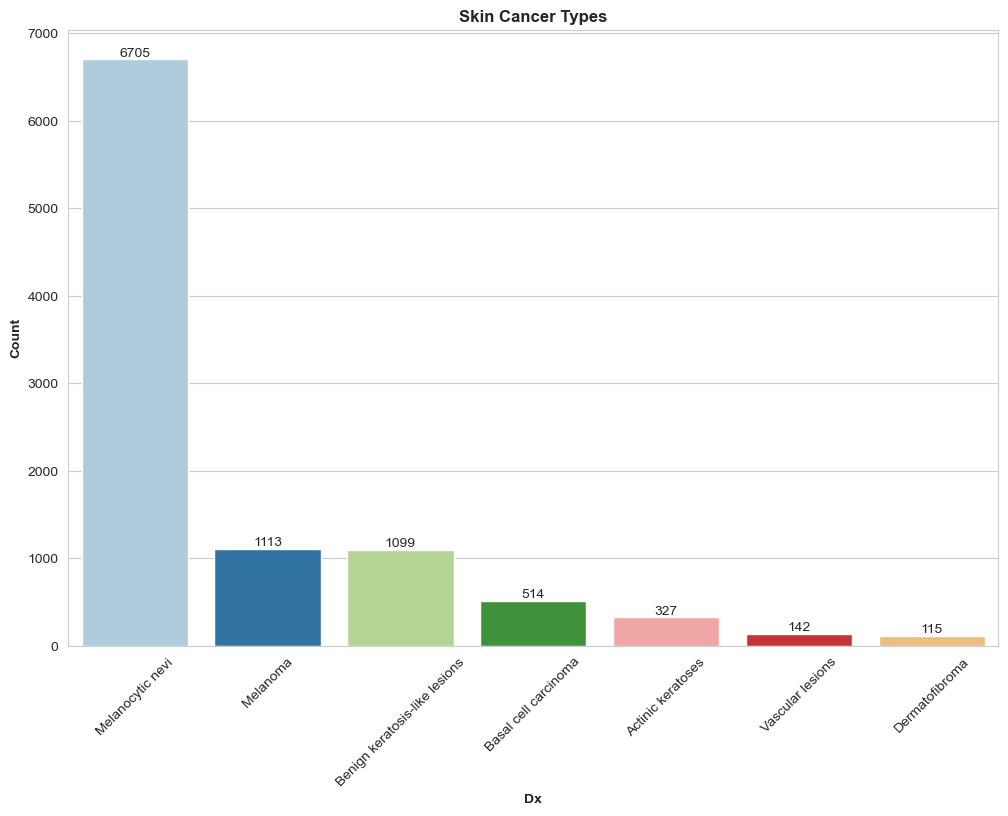

In [37]:
EDA_plots(data = metadata, variable = "dx", title = "Skin Cancer Types", colors = "Paired")

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

### Diagnosis basis

Here, we look at the distribution of the diagnosis basis. This indicates how the ground truth was obtained (for more detail information please check the data source information).

The diagnosis (ground truth) is obtained by either:
**1. Histopathology(Histo):**  Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists. <br>
**2. Confocal:** Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after  manual histogram changes.<br>
**3. Follow-up:** If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists  accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions. <br>
**4. Consensus:** For typical benign cases without histopathology or followup biologists  provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

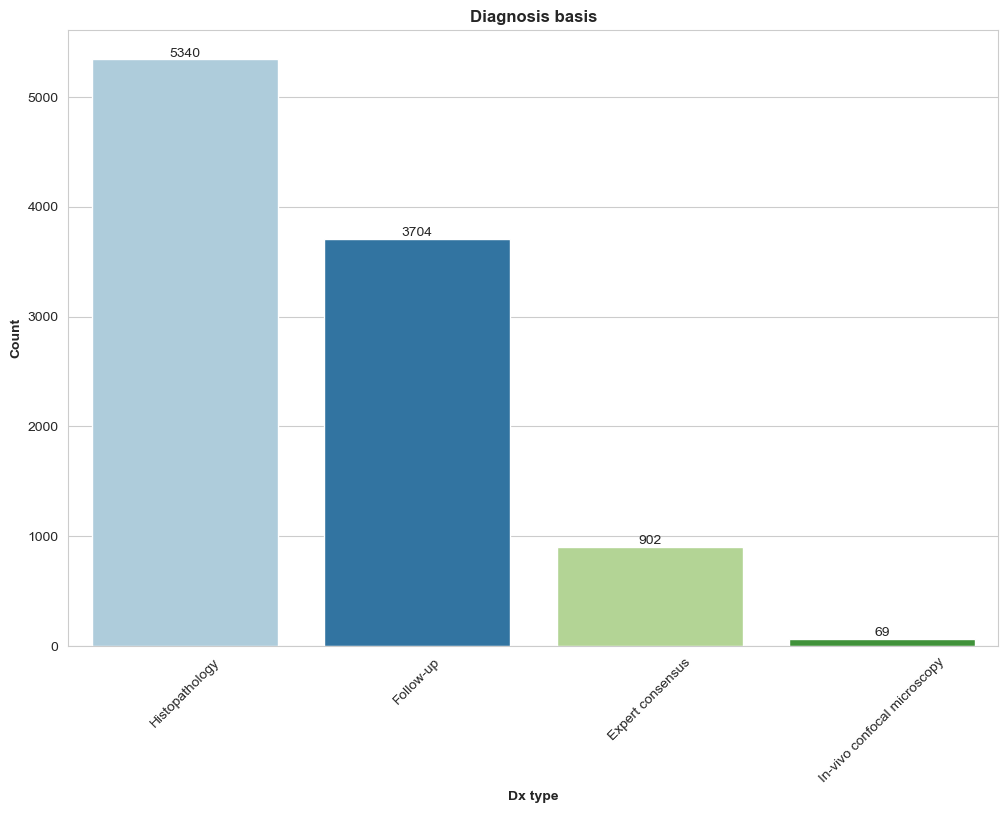

In [38]:
EDA_plots(data=metadata, variable="dx_type", title="Diagnosis basis")

We can also look if diagnosis vary across genders.

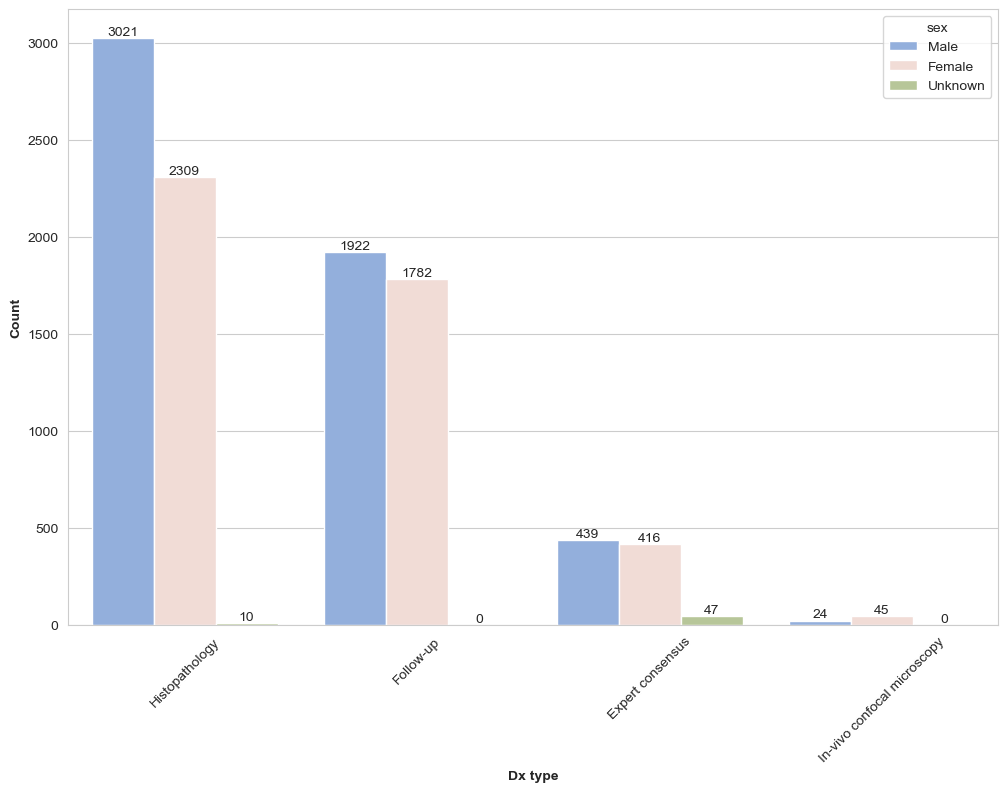

In [39]:
EDA_plots(data=metadata, variable="dx_type", hue="sex", colors=gender_colors)

### Lesion localization

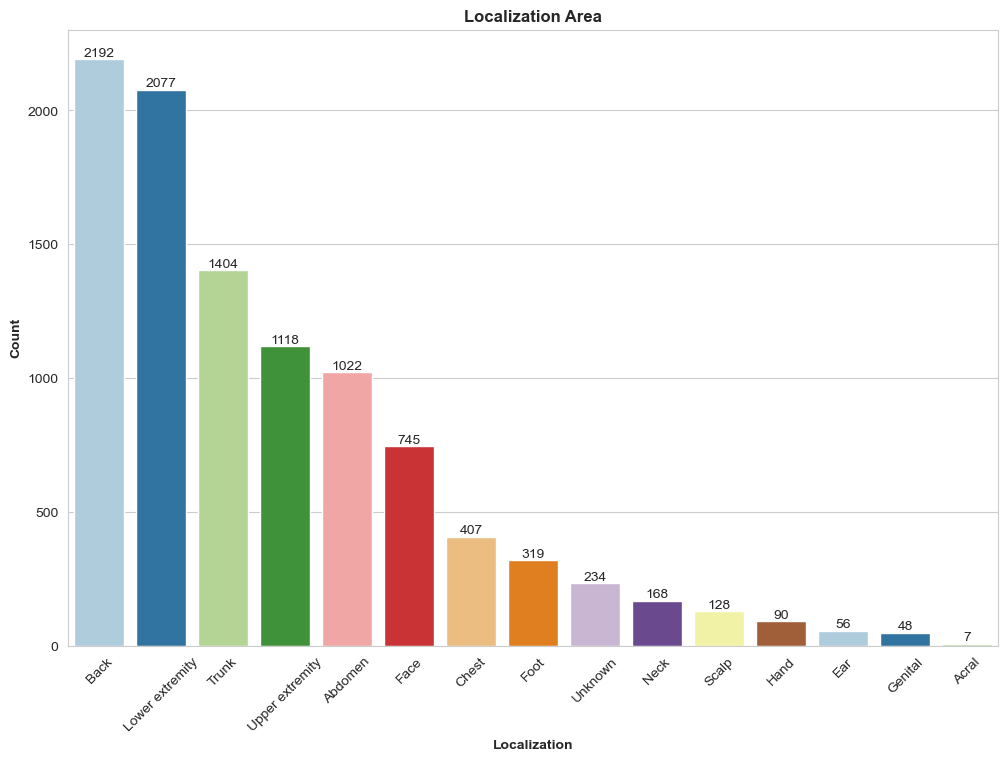

In [40]:
EDA_plots(data=metadata, variable="localization", title="Localization Area")

Data shows that the back and lower extremities are the most frequent place for skin lesions.

Again, we could split this histogram by gender to investigate for differences.

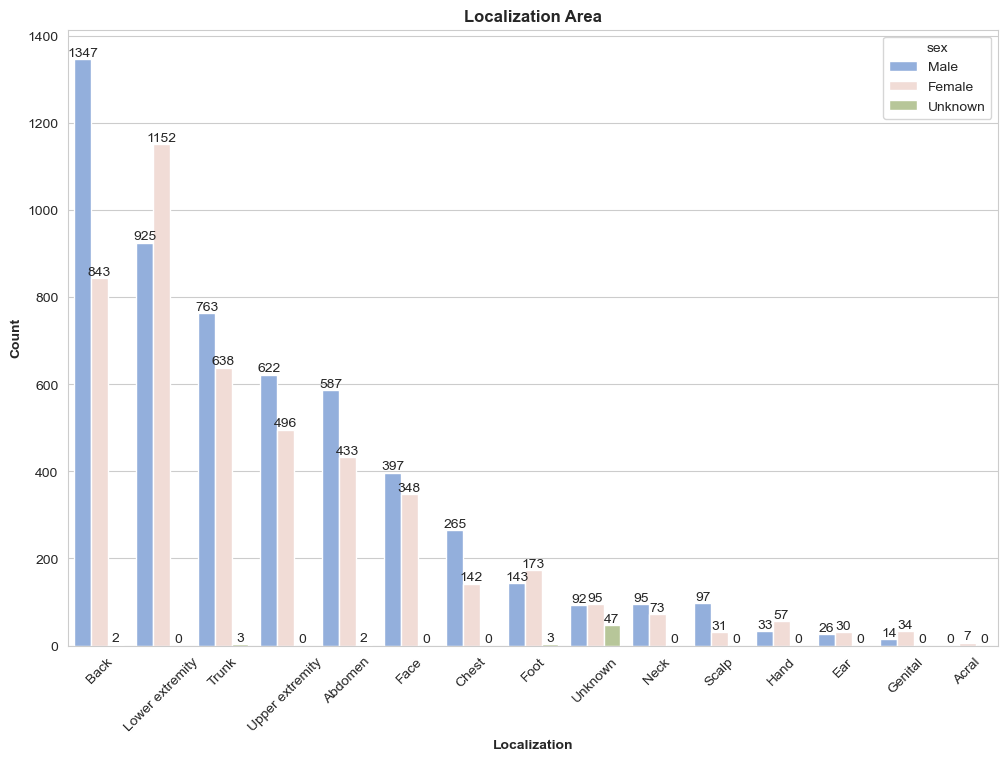

In [41]:
EDA_plots(data=metadata, variable="localization", hue="sex", title="Localization Area", colors=gender_colors)

Men exhibit skin lesions in more than 50% of the time compared to women. On the other hand, for women, the most frequent place for skin lesions are the lower extrimities.

### Gender distribution

Lets see the distribution of males and females

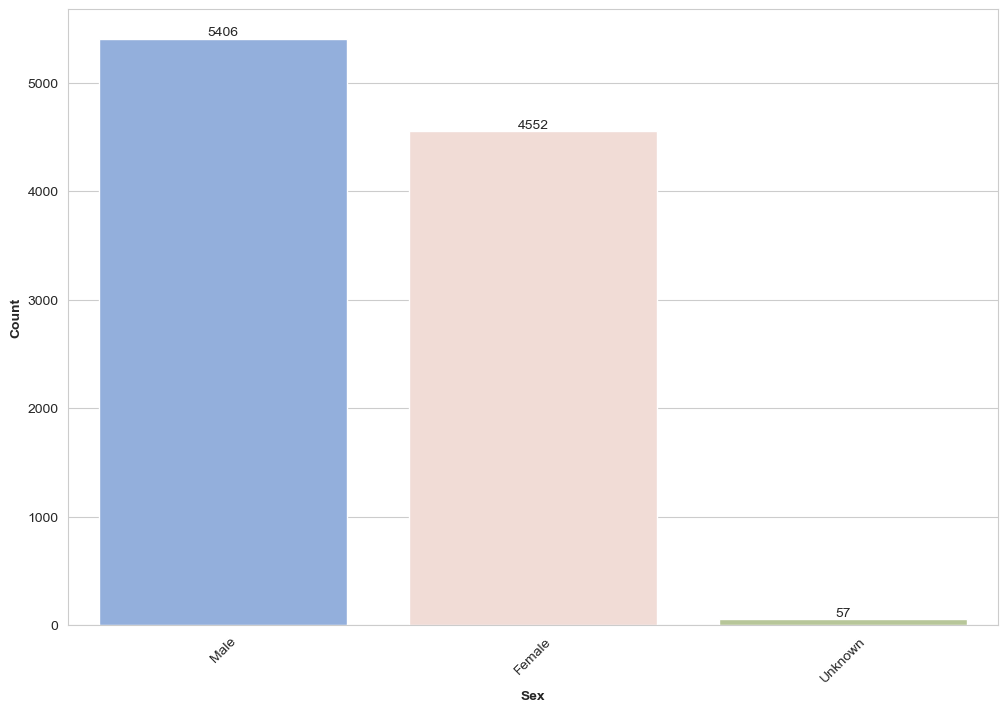

In [42]:
EDA_plots(data=metadata, variable="sex", colors=gender_colors)

### Age distribution

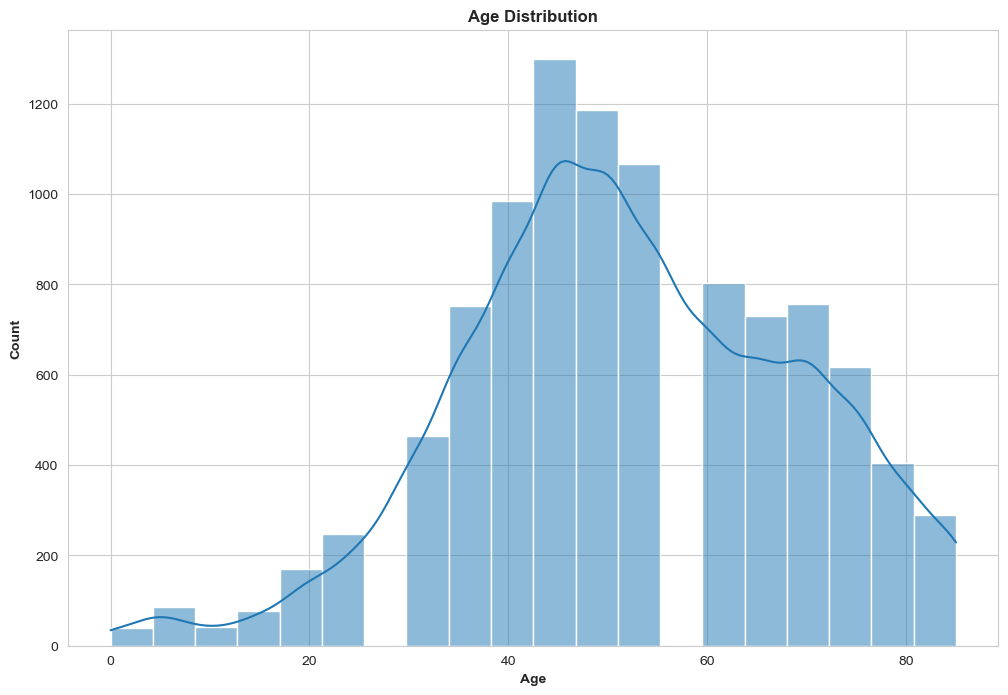

In [43]:
EDA_plots(data=metadata, variable="age", kind="hist", title="Age Distribution", hist_args={"kde": True, "bins": 20})

We can also look at the age distribution by gender.

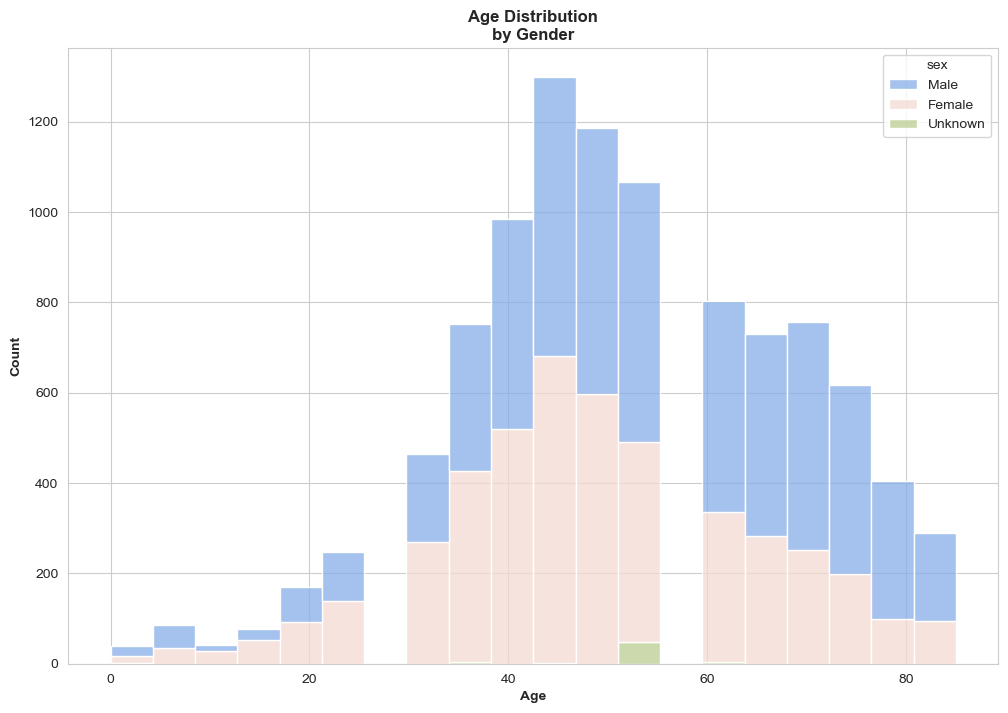

In [44]:
EDA_plots(data=metadata, variable="age", hue="sex", kind="hist", title="Age Distribution\nby Gender", colors=gender_colors, hist_args={"kde": False, "bins": 20, "multiple": "stack"})

### Diagnosis by gender

In [45]:
for gender in metadata.sex.unique():
    print(f"Gender: {gender}")
    subset = metadata[metadata.sex == gender].groupby("dx").size().reset_index().rename(columns={0: "#"})
    subset["%"] = (subset["#"] / subset["#"].sum()).round(2)
    display(subset.sort_values("#", ascending=False))
    print("\n")

Gender: Male


,dx,#,%
4,Melanocytic nevi,3421,0.63
5,Melanoma,689,0.13
2,Benign keratosis-like lesions,626,0.12
1,Basal cell carcinoma,317,0.06
0,Actinic keratoses,221,0.04
6,Vascular lesions,69,0.01
3,Dermatofibroma,63,0.01




Gender: Female


,dx,#,%
4,Melanocytic nevi,3237,0.71
2,Benign keratosis-like lesions,463,0.10
5,Melanoma,424,0.09
1,Basal cell carcinoma,197,0.04
0,Actinic keratoses,106,0.02
6,Vascular lesions,73,0.02
3,Dermatofibroma,52,0.01




Gender: Unknown


,dx,#,%
1,Melanocytic nevi,47,0.82
0,Benign keratosis-like lesions,10,0.18


### Visual inspection of images

Since we are dealing with image data, it is also useful to visually inspect a sample of them.

#### Resizing images

For computing efficiency, we resize the images from 600 x 450 px into 100 x 75 px.

In [46]:
if LOAD_DATA:
    metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
    np.save("image_array.npy", metadata["image"].to_numpy(), allow_pickle=True)
else:
    metadata['image'] = np.load("image_arrays.npy", allow_pickle=True)

Showing a random sample of 5 lesions per diagnosis.

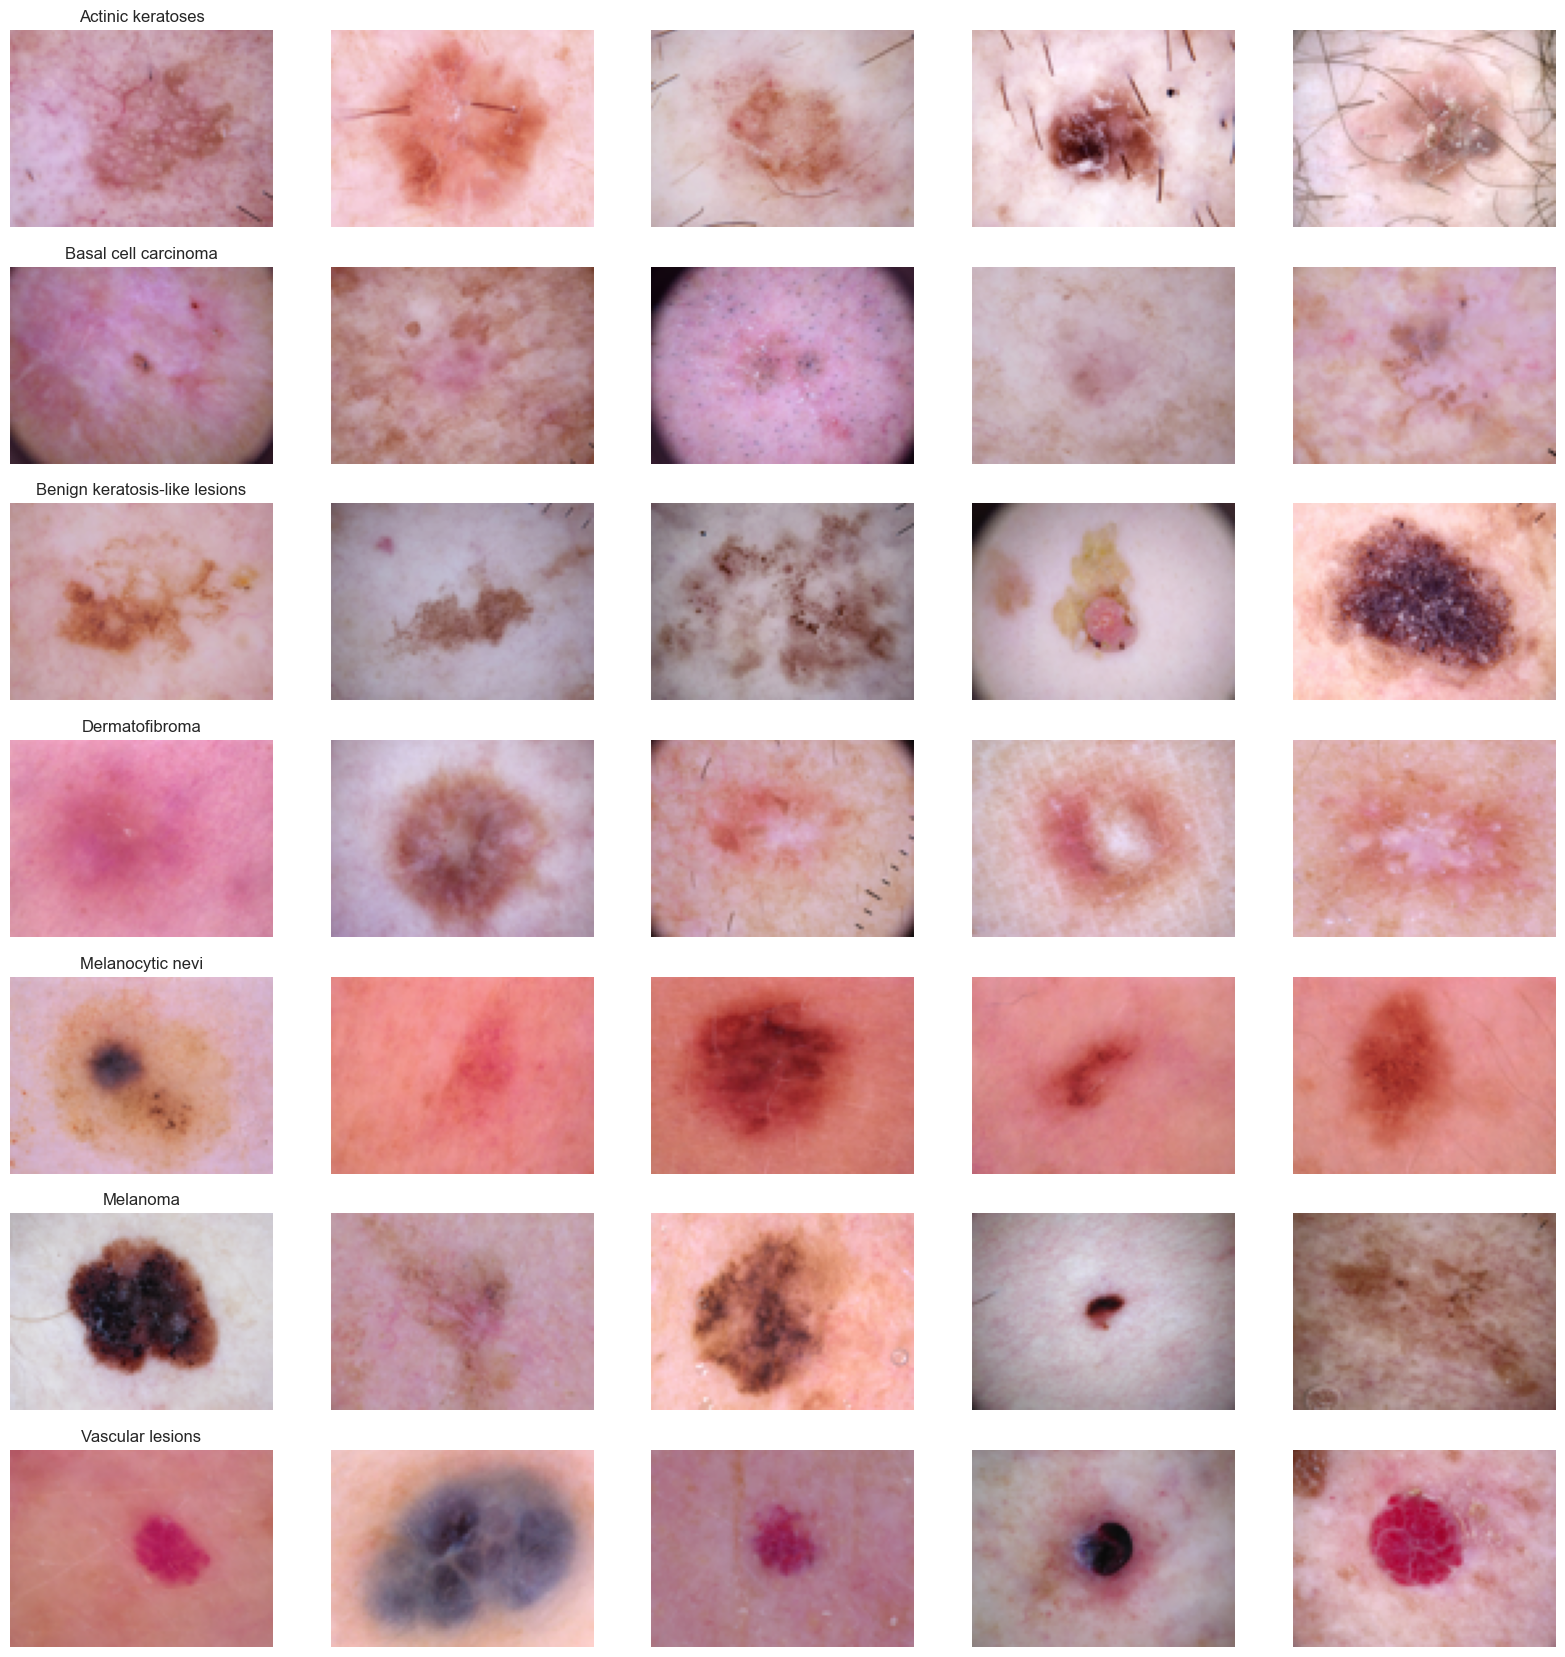

In [47]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         metadata.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=SEED).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
#fig.savefig('lesion_samples.png', dpi=300)

## Data Preprocessing

### Data split

In [48]:
features = metadata["image"]
labels = metadata['dx'].map({i: k for k, v in mapping["cancer"].items() for i in v})

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = 0.20, random_state=SEED)

### Standardization

We normalize the features Train and Test sets by substracting the mean and dividing by the standard deviation.

In [49]:
X_train = np.asarray(X_train.tolist())
X_val_ix = X_val.index
X_val = np.asarray(X_val.tolist())

X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std

### Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors 

In [50]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

### Reshape back to 3-channel image

Since we had flatten the arrays to perform standardization, we now reshape back to  3 dimensions (height = 75px, width = 100px , canal = 3)

In [51]:
X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_val = X_val.reshape(X_val.shape[0], *(75, 100, 3))

## Classifier

### Model Building: CNN

We will use a CNN with the following architecture:
 - Convolutional layers of 32 filters (x2) and 64 filters (x2)
 - Max-Pool layers
 - Dropout layers for regularization
 - ReLu activation functions
 - Softmax function for final probabilities

In [52]:

model = build_CNN(input_shape = (75, 100, 3),  num_classes = 2, metrics = [keras.metrics.AUC(), "accuracy", precision, recall, f1_score])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 75, 100, 32)       896       
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 37, 50, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 50, 64)        36928     
                                                      

In [53]:
plot_model(model, to_file='model_plot.png', rankdir="TB", show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=100)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Data Augmentation

To avoid overfitting, we expand artificially our training data by data augmentation. This sould also aid the cross-dataset approach we are aiming to apply here. We will only apply small degree rotations, zoomming, width and height shifts.

In [54]:
# Data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train, seed=SEED)




### Training the model

For efficiency, a previously trained model is saved as "model.keras". If you prefer to re-train the model from scratch, set the flag to TRUE. 

NOTE: If the model is not saved, the training will begin automatically.

In [55]:
TRAIN = False

if not TRAIN:
    try:
        print("Trying to load a saved model...")
        model = keras.models.load_model('model.keras')
        model_history = json.loads(open("train_history.json").read())
        print("Model successfully loaded.")
    except:
        print("Couldn't load model. Training again...")
        TRAIN = True

if TRAIN:
    # Fit the model
    epochs = 50
    batch_size = 10
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='auc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size*3, seed=SEED),
                                epochs = epochs, validation_data = (X_val , y_val),
                                verbose = 1, 
                                callbacks=[learning_rate_reduction])
    
    # Save trained model
    model.save("model_B.keras")
    model_history = history.history

    seriaz_history = convert_history(model_history)

    # Save training history
    json_object = json.dumps(history.history)
    with open(f"train_history_B.json", "w") as outfile:
        outfile.write(json_object)




Trying to load a saved model...
Couldn't load model. Training again...
Epoch 1/50
268/268 [==============================] - 110s 406ms/step - loss: 0.4423 - auc_1: 0.8804 - accuracy: 0.8366 - precision: 0.8372 - recall: 0.8372 - f1_score: 0.8372 - val_loss: 0.3953 - val_auc_1: 0.8909 - val_accuracy: 0.8342 - val_precision: 0.8350 - val_recall: 0.8350 - val_f1_score: 0.8350 - lr: 0.0010
Epoch 2/50
268/268 [==============================] - 108s 402ms/step - loss: 0.3913 - auc_1: 0.8984 - accuracy: 0.8384 - precision: 0.8389 - recall: 0.8389 - f1_score: 0.8389 - val_loss: 0.3819 - val_auc_1: 0.9018 - val_accuracy: 0.8342 - val_precision: 0.8350 - val_recall: 0.8350 - val_f1_score: 0.8350 - lr: 0.0010
Epoch 3/50
268/268 [==============================] - 310s 1s/step - loss: 0.3804 - auc_1: 0.9062 - accuracy: 0.8384 - precision: 0.8389 - recall: 0.8389 - f1_score: 0.8389 - val_loss: 0.3767 - val_auc_1: 0.9101 - val_accuracy: 0.8342 - val_precision: 0.8350 - val_recall: 0.8350 - val_f1_sc

#### Train History

We plot the train history to check for underfitting/overfitting.

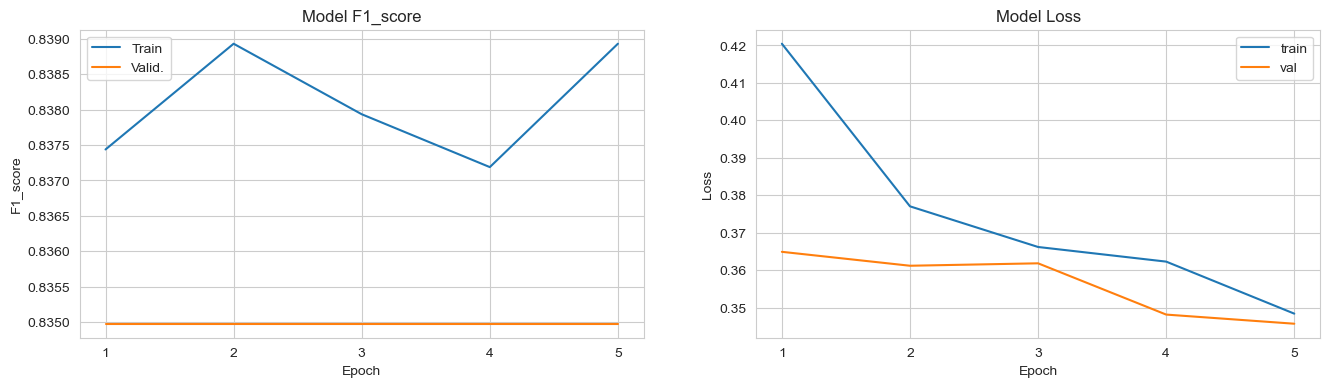

In [ ]:
plot_model_train_history(model_history, metric="f1_score")

### Model Evaluation

We check the F1-Score and Loss for the training and validation datasets, along with the final loss and AUC.

63/63 [==============================] - 7s 115ms/step - loss: 0.3457 - auc: 0.9224 - accuracy: 0.8342 - precision: 0.8350 - recall: 0.8350 - f1_score: 0.8350


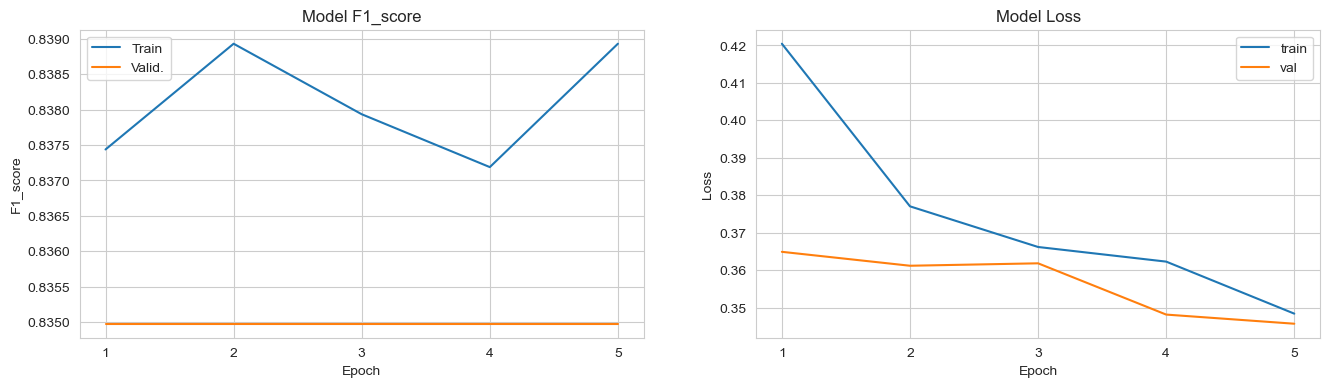

Validation: AUC = 0.92  | F1-Score: 0.83 | Loss = 0.35


In [ ]:
results = model.evaluate(X_val, y_val, verbose=1, return_dict=True)

plot_model_train_history(model_history, metric="f1_score")

print(f"Validation: AUC = {results['auc']:.2f}  | F1-Score: {results['f1_score']:.2f} | Loss = {results['loss']:.2f}")

#### Main performance metrics, Confusion Matrix and Precision-Recall curve

We also plot the confusion matrix, to have more insights into the misclassifications.

63/63 [==============================] - 8s 121ms/step
Accuracy : 0.83
Precision : 0.00
Recall : 0.00


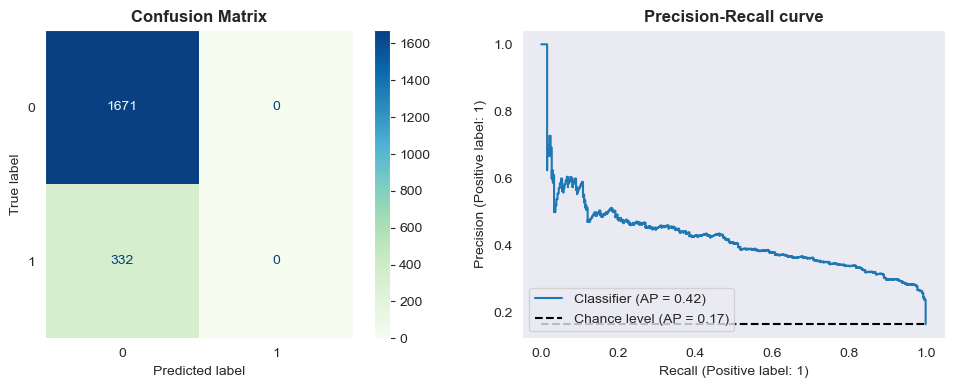

In [ ]:
evaluate_model(model, X_val, y_test=y_val)

We can observe that the classifier has good accuracy and precision, but poor recall on Cancer. This is sub-optimal, since we would like the classifier to catch most of the cancer lesions, even if that means less accuracy. We can try to adjust the threshold to improve the recall of class 1.

#### Modified Threshold

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Accuracy : 0.76
Precision : 0.39
Recall : 0.80


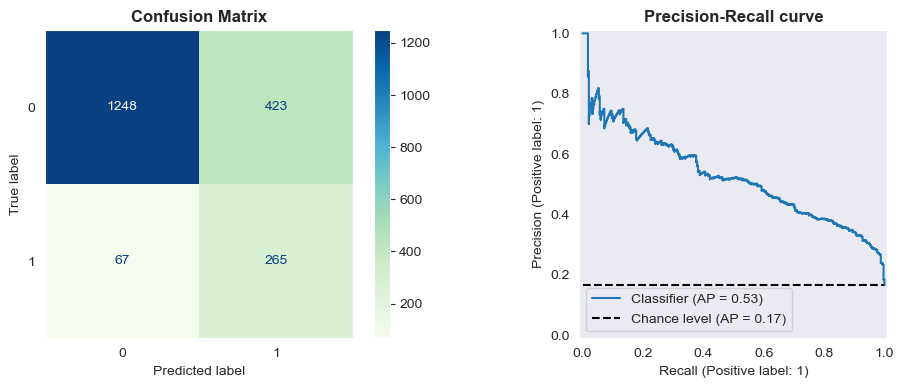

In [ ]:
evaluate_model(model, X_val, y_test=y_val, threshold=0.25)

We can see that adjusting the threshold to 0.25 improves greatly the recall for class cancer, while reducing drastically precision (this is an inevitable trade-off) and losing also some accuracy.

#### Mis-classified images

Finally, we'll visually inspect some of the mis-classified lesions for insights.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


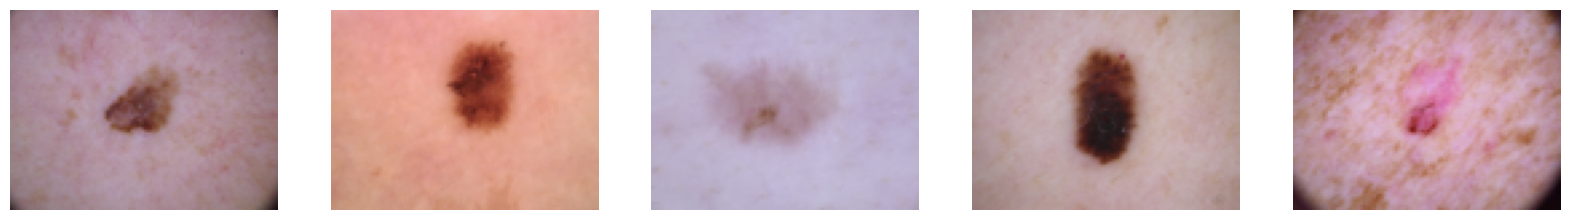

In [ ]:
y_pred = np.argmax(model.predict(X_val), axis = 1)
y_true = np.argmax(y_val, axis = 1)

n_samples = 5
fig, ax = plt.subplots(1, n_samples, figsize = (4*n_samples, 4))

for ix, img in enumerate(metadata.loc[X_val_ix[y_pred !=  y_true], "image"].sample(n=5, random_state=SEED)):
    ax[ix].imshow(img)
    ax[ix].axis('off')